**Import Libraries**

In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

**Import Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
datasetdir = '/content/drive/MyDrive/Bird'
os.chdir(datasetdir)


In [4]:
# Load file locations
df_info = pd.read_excel('dataset_information.xlsx', sheet_name = 'images.txt')

#Load class information
df_classes = pd.read_excel('dataset_information.xlsx', sheet_name = 'classes.txt')

#Read Train Test Split details
df_train_test = pd.read_csv('train_test_split.csv')

In [6]:
df_classes.head(10)

,child_class_id,class_description
0,1,"Ducks, Geese, and Swans"
1,2,"Grouse, Quail, and Allies"
2,3,Loons
3,4,Grebes
4,5,Storks
5,6,"Frigatebirds, Boobies, Cormorants, Darters, an..."
6,7,"Pelicans, Herons, Ibises, and Allies"
7,8,"Hawks, Kites, Eagles, and Allies"
8,9,Caracaras and Falcons
9,10,Cranes and Rails


In [7]:
#Split the class and imange name
df_image = df_info.join(df_info['image_location'].str.split('/',expand=True).rename(columns={0:'class_id',1:'image_name'})) 

In [8]:
df_image.tail(10)

,image_id,image_location,class_id,image_name
48552,ffef2e23-edd7-4221-88a8-074ac0773d77,0786/ffef2e23edd7422188a8074ac0773d77.jpg,0786,ffef2e23edd7422188a8074ac0773d77.jpg
48553,ffef9325-d321-4129-825d-2d7dddeeb824,0980/ffef9325d3214129825d2d7dddeeb824.jpg,0980,ffef9325d3214129825d2d7dddeeb824.jpg
48554,fff0b2c3-5ab3-4c64-b160-a77398fe5a46,0527/fff0b2c35ab34c64b160a77398fe5a46.jpg,0527,fff0b2c35ab34c64b160a77398fe5a46.jpg
48555,fff1d97b-2ac3-410d-8c6d-7430470bb951,0503/fff1d97b2ac3410d8c6d7430470bb951.jpg,0503,fff1d97b2ac3410d8c6d7430470bb951.jpg
48556,fff3ec39-07d4-4600-b753-12013066277f,0999/fff3ec3907d44600b75312013066277f.jpg,0999,fff3ec3907d44600b75312013066277f.jpg
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,0891/fff86e8b795f400a91e8565bbb8c453a.jpg,0891,fff86e8b795f400a91e8565bbb8c453a.jpg
48558,fff926d7-ccad-4788-839e-97af2dd99372,0660/fff926d7ccad4788839e97af2dd99372.jpg,0660,fff926d7ccad4788839e97af2dd99372.jpg
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,0492/fffa33efa765408d8d666efc7f504c71.jpg,0492,fffa33efa765408d8d666efc7f504c71.jpg
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,0372/ffff0d87bc844ef2a47ea4bfa48502ce.jpg,0372,ffff0d87bc844ef2a47ea4bfa48502ce.jpg
48561,fffff3a5-2a75-47d0-887f-03871e3f9a37,0880/fffff3a52a7547d0887f03871e3f9a37.jpg,0880,fffff3a52a7547d0887f03871e3f9a37.jpg


In [9]:
#Convert the string column to INT to chop leading zeroes
df_image['class_id'] = df_image['class_id'].astype(int)

In [10]:
#Join the information and class dataframe 
df_bird = pd.merge(df_image, df_classes, left_on='class_id', right_on='child_class_id', how='left').drop('child_class_id', axis=1)

In [11]:
df_bird.head(10)

,image_id,image_location,class_id,image_name,class_description
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,817,0000139e21dc4d0cbfe14cae3c85c829.jpg,Oak Titmouse
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,860,0000d9fc4e024c06a0afa55cfb16b12b.jpg,Ovenbird
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,900,000193069d834334b255a447742edce3.jpg,Savannah Sparrow
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,645,0001afd499a14a67b940d419413e23b3.jpg,Eared Grebe (Nonbreeding/juvenile)
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,929,000332b8997c454096472f0a8495aecf.jpg,Eastern Phoebe
5,000343bd-5215-49ba-ab9c-7c97a70ac1a5,0652/000343bd521549baab9c7c97a70ac1a5.jpg,652,000343bd521549baab9c7c97a70ac1a5.jpg,Yellow-crowned Night-Heron (Immature)
6,0004ff8d-0cc8-47ee-94ba-43352a8b9eb4,0951/0004ff8d0cc847ee94ba43352a8b9eb4.jpg,951,0004ff8d0cc847ee94ba43352a8b9eb4.jpg,Florida Scrub-Jay
7,0007181f-a727-4481-ad89-591200c61b9d,0900/0007181fa7274481ad89591200c61b9d.jpg,900,0007181fa7274481ad89591200c61b9d.jpg,Savannah Sparrow
8,00071e20-8156-4bd8-b5ca-6445c2560ee5,0988/00071e2081564bd8b5ca6445c2560ee5.jpg,988,00071e2081564bd8b5ca6445c2560ee5.jpg,Yellow-headed Blackbird (Female/Immature Male)
9,0007acfc-c0e6-4393-9ab6-02215a82ef63,0400/0007acfcc0e643939ab602215a82ef63.jpg,400,0007acfcc0e643939ab602215a82ef63.jpg,Herring Gull (Adult)


In [12]:
#Find the count of bird class in case only specific classes need to be to the model
df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

,class_id,count
523,979,120
446,902,120
275,672,120
80,397,120
400,856,120
...,...,...
550,1006,25
299,755,24
33,341,23
267,664,21


In [13]:
#Find the count of bird class in case only specific classes need to be to the model
df_classcounts = df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

In [14]:
#Selected only specific labels
target_class = df_classcounts[(df_classcounts['count']>=60) & (df_classcounts['count']<=120)]['class_id'].values

df_bird['FILTERED_LABEL'] = (df_bird.class_id.isin(target_class)).astype('int')

In [15]:
df_classcounts['count'].values

array([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117,
       117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
       116, 116, 116, 116, 115, 115, 115, 115, 114, 114, 114, 114, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112,
       111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 10

In [16]:
df_target =  df_bird[df_bird['FILTERED_LABEL']==1]

In [17]:
df_target.shape

(43955, 6)

In [18]:
df_target['class_id'] = df_target['class_id'].astype(str)
df_target['image_location'] = df_target['image_location'].astype(str)

In [19]:
datasetdir = '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled'
os.chdir(datasetdir)


**Prepare Training and Validation Set**

In [20]:
df_train_test.head(10)

,image,train
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0
2,00019306-9d83-4334-b255-a447742edce3,0
3,0001afd4-99a1-4a67-b940-d419413e23b3,1
4,000332b8-997c-4540-9647-2f0a8495aecf,0
5,000343bd-5215-49ba-ab9c-7c97a70ac1a5,0
6,0004ff8d-0cc8-47ee-94ba-43352a8b9eb4,0
7,0007181f-a727-4481-ad89-591200c61b9d,1
8,00071e20-8156-4bd8-b5ca-6445c2560ee5,1
9,0007acfc-c0e6-4393-9ab6-02215a82ef63,0


In [21]:
#Join the target and train test dataframe 
df_target = pd.merge(df_target, df_train_test, left_on='image_id', right_on='image', how='left').drop('image', axis=1)

In [22]:
df_train =  df_target[df_target['train']==1]
df_train.shape

(21768, 7)

In [23]:
X_train = df_train['image_location']
y_train = df_train['class_id']

In [24]:
df_valtest =  df_target[df_target['train']==0]
df_valtest.shape

(22187, 7)

In [25]:
X_val, X_test, y_val, y_test = train_test_split(df_valtest['image_location'], df_valtest['class_id'], test_size=0.25, random_state=44)
TotalImages = len(X_train) + len(X_val) + len(X_test)
print("Number of images for training: ", len(X_train))
print("Number of images for validation: ", len(X_val))
print("Number of images for testing: ", len(X_test))
print("Total Images in Train Test Val Set is: ",TotalImages )

Number of images for training:  21768
Number of images for validation:  16640
Number of images for testing:  5547
Total Images in Train Test Val Set is:  43955


In [27]:
X_train = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_val]
y_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in y_val]
X_train[:3]

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0645/0001afd499a14a67b940d419413e23b3.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0900/0007181fa7274481ad89591200c61b9d.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0988/00071e2081564bd8b5ca6445c2560ee5.jpg']

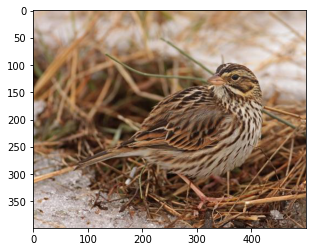

In [28]:
plt.imshow(Image.open(X_train[1]))

**Encode the Target Labels**

In [29]:
y_train.shape

(21768,)

In [30]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [31]:
lb.classes_

array(['1000', '1001', '1002', '1003', '1004', '1005', '1009', '1010',
       '296', '297', '298', '299', '314', '315', '316', '317', '318',
       '319', '320', '321', '322', '323', '324', '325', '326', '327',
       '328', '329', '332', '333', '335', '336', '337', '338', '339',
       '340', '343', '344', '346', '347', '348', '349', '350', '351',
       '352', '353', '354', '355', '356', '357', '358', '359', '362',
       '363', '364', '365', '366', '367', '368', '370', '371', '372',
       '373', '374', '375', '376', '377', '378', '379', '380', '381',
       '382', '393', '395', '396', '397', '398', '399', '400', '401',
       '402', '446', '448', '449', '450', '451', '452', '453', '454',
       '457', '458', '459', '461', '462', '468', '469', '470', '471',
       '472', '473', '474', '475', '476', '477', '478', '479', '480',
       '481', '482', '483', '484', '485', '486', '487', '488', '489',
       '490', '491', '493', '494', '495', '496', '498', '499', '500',
       '501', '503'

In [32]:
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)
y_test_bin = lb.transform(y_test)
y_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((21768, 453), (16640, 453), (5547, 453))

In [33]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
N_CLASSES = len(lb.classes_)

In [34]:
def parse_img_label(filename, label):

    # Read an image from a file
    image_string = tf.io.read_file(filename)

    # Decode it into a  vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)

    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])

    # Normalize the image
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

In [35]:
BATCH_SIZE = 512 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 256

In [36]:
def gen_dataset(filenames, labels, is_training=True):

 
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_img_label, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [37]:
train_ds = gen_dataset(X_train, y_train_bin)
val_ds = gen_dataset(X_val, y_val_bin)
test_ds = gen_dataset(X_test,y_test_bin)

In [38]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (512, 224, 224, 3)
Shape of labels array: (512, 453)


**Prepare Transfer Learning Model - HUB MobileNet**

In [39]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [40]:
feature_extractor_layer.trainable = False

In [41]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(2048, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu', name='hidden_layer2'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer3'),
    layers.Dense(N_CLASSES, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 2048)              2623488   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 453)               2

**Define MACRO F1 Score for multi-class**

In [42]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [4]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

NameError: ignored

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
     metrics=[macro_f1, 'accuracy'] )
    

In [ ]:
batch_size = 256
history = model.fit(train_ds,batch_size=batch_size, epochs=50, validation_data=val_ds,validation_batch_size= batch_size, 
                    callbacks=[model_checkpoint_callback])

Epoch 1/50
43/43 [==============================] - 143s 3s/step - loss: 0.0156 - macro_f1: 0.0000e+00 - accuracy: 0.0157 - val_loss: 0.0021 - val_macro_f1: 0.0000e+00 - val_accuracy: 1.2019e-04
Epoch 2/50
43/43 [==============================] - 142s 3s/step - loss: 0.0146 - macro_f1: 0.0000e+00 - accuracy: 0.0334 - val_loss: 0.0021 - val_macro_f1: 0.0000e+00 - val_accuracy: 1.2019e-04
Epoch 3/50
43/43 [==============================] - 138s 3s/step - loss: 0.0133 - macro_f1: 5.1337e-05 - accuracy: 0.0629 - val_loss: 0.0022 - val_macro_f1: 0.0000e+00 - val_accuracy: 6.0096e-05
Epoch 4/50
43/43 [==============================] - 141s 3s/step - loss: 0.0121 - macro_f1: 8.5904e-04 - accuracy: 0.1011 - val_loss: 0.0022 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/50
43/43 [==============================] - 140s 3s/step - loss: 0.0110 - macro_f1: 0.0043 - accuracy: 0.1454 - val_loss: 0.0021 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/50
43/43 [===========

In [ ]:
model.load_weights(checkpoint_filepath)

**Evaluate the Model**

In [ ]:
model.evaluate(test_ds, return_dict=True)

11/11 [==============================] - 23s 2s/step - loss: 0.0089 - macro_f1: 0.2563 - accuracy: 0.4774


{'accuracy': 0.4773751497268677,
 'loss': 0.008934330195188522,
 'macro_f1': 0.2563462555408478}

**Model Performance**

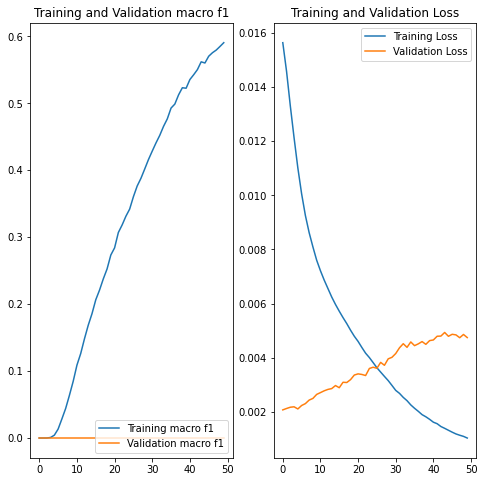

In [ ]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/Bird/model') 

**Show Predicted Images**

In [ ]:
def show_prediction(model, img_path, df_target):

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = lb.classes_
    prediction = prediction[prediction==1].index.values
    print("\n Predicted Bird Class : " ,prediction)

    class_description ="Not Found"

    #Get the class description of the bird
    if prediction[0] != "" :
      class_description = df_target.loc[df_target['class_id']== prediction[0]]['class_description'].iloc[0]
    else:
      prediction = "Not Found"


    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\nPrediction\n{}\n'.format(list(prediction)), fontsize=9)
    plt.title('\nBird class\n{}\n'.format(class_description), fontsize=9)
    plt.show()

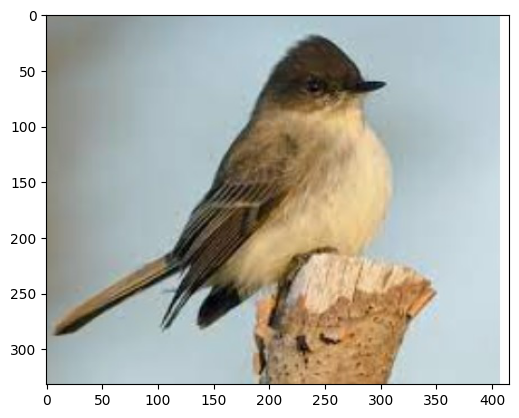

In [ ]:
img_path='/content/drive/MyDrive/Bird/bird_predict/003.jpg'
plt.imshow(Image.open(img_path))


 Predicted Bird Class :  ['929']


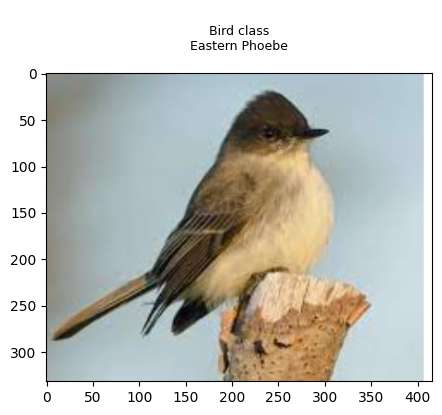

In [ ]:
show_prediction(model,img_path, df_target )

**IMAGENET Model 140_224**

**Prepare the dataset with different Train Test Split**

In [45]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df_target['image_location'], df_target['class_id'], test_size=0.05, random_state=44)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=1/5, train_size=4/5, random_state=44)

print("Number of posters for training: ", len(X1_train))
print("Number of posters for validation: ", len(X1_val))
print("Number of posters for testing: ", len(X1_test))

Number of posters for training:  33405
Number of posters for validation:  8352
Number of posters for testing:  2198


In [46]:
y1_train_bin = lb.transform(y1_train)
y1_val_bin = lb.transform(y1_val)
y1_test_bin = lb.transform(y1_test)
y1_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((33405, 453), (16640, 453), (5547, 453))

In [47]:
train_ds1 = gen_dataset(X1_train, y1_train_bin)
val_ds1 = gen_dataset(X1_val, y1_val_bin)
test_ds1 = gen_dataset(X1_test,y1_test_bin)

**Build the model**

In [48]:
base_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])
base_model.build([None, 224, 224, 3])

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 453)               812229    
Total params: 5,175,941
Trainable params: 812,229
Non-trainable params: 4,363,712
_________________________________________________________________


In [49]:
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy']  )

In [50]:
batch_size = 256
EPOCHS = 50
history = base_model.fit(train_ds1,batch_size=batch_size, epochs=EPOCHS, validation_data=val_ds1,validation_batch_size= batch_size)


Epoch 1/50
66/66 [==============================] - 199s 3s/step - loss: 0.2076 - macro_f1: 0.0000e+00 - accuracy: 0.0018 - val_loss: 0.0196 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0023
Epoch 2/50
66/66 [==============================] - 193s 3s/step - loss: 0.0189 - macro_f1: 0.0000e+00 - accuracy: 0.0039 - val_loss: 0.0177 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0102
Epoch 3/50
66/66 [==============================] - 188s 3s/step - loss: 0.0173 - macro_f1: 0.0000e+00 - accuracy: 0.0144 - val_loss: 0.0166 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0384
Epoch 4/50
66/66 [==============================] - 189s 3s/step - loss: 0.0164 - macro_f1: 0.0000e+00 - accuracy: 0.0499 - val_loss: 0.0158 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0873
Epoch 5/50
66/66 [==============================] - 189s 3s/step - loss: 0.0156 - macro_f1: 0.0000e+00 - accuracy: 0.0991 - val_loss: 0.0151 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.1346
Epoch 6/50
66/66 [===========================

**Performance of the Model**

In [2]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

**Evaluate the Model**

In [3]:
model.evaluate(test_ds1, return_dict=True)

NameError: ignored